In [1]:
import torch
from tqdm.auto import tqdm
from torch.optim import AdamW
from transformers import get_scheduler
from optree import tree_map_, tree_map
import pickle
import matplotlib.pyplot as plt

import uqlib

from load import load_dataloaders, load_model

In [14]:
# Load data
train_dataloader, eval_dataloader = load_dataloaders(small=True, batch_size=16)
num_data = len(train_dataloader.dataset)
print("Full training data size: ", num_data)

Full training data size:  1000


In [3]:
# Load model (with standard Gaussian prior)
model, param_to_log_posterior = load_model(num_data=num_data, prior_sd=1e3)

# Turn off Dropout
model.eval()

# Load to GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device);

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Only train the last layer
for name, param in model.named_parameters():
    if 'bert' in name:
        param.requires_grad = False

In [5]:
init_params = tree_map(lambda x: x.detach().clone(), dict(model.named_parameters()))

In [6]:
# Train (as usual, using native PyTorch) for MAP
optimizer = AdamW(model.parameters(), lr=1e-3, maximize=True)

num_epochs = 30
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)


progress_bar = tqdm(range(num_training_steps))

log_posts = []

# model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        log_post = param_to_log_posterior(dict(model.named_parameters()), batch)

        log_post.backward()
        log_posts.append(log_post.item())
        
        print(log_posts[-1], end='\r')

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/960 [00:00<?, ?it/s]

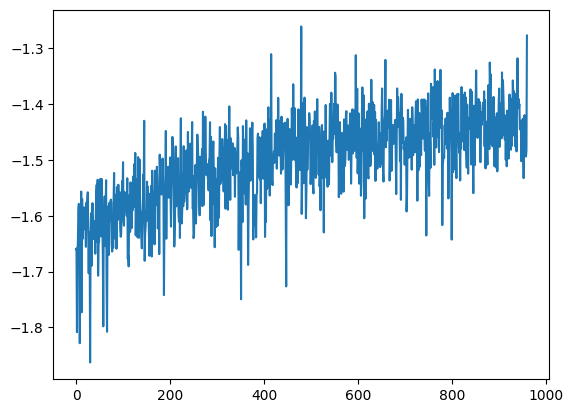

In [10]:
plt.plot(log_posts);

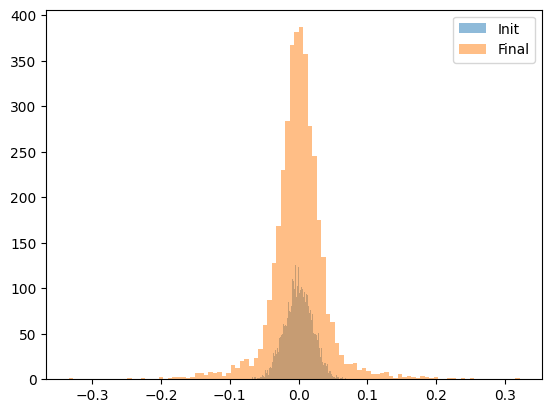

In [12]:
final_params = tree_map(lambda p: p.detach().clone(), dict(model.named_parameters()))

init_untrained_params = torch.cat([v.flatten() for k, v in init_params.items() if 'bert' not in k])
final_untrained_params = torch.cat([v.flatten() for k, v in final_params.items() if 'bert' not in k])

plt.hist(init_untrained_params.cpu().numpy(), bins=100, alpha=0.5, label='Init')
plt.hist(final_untrained_params.cpu().numpy(), bins=100, alpha=0.5, label='Final')
plt.legend();

In [17]:
# Jacobian requires more memory, so we'll use a smaller batch size for the Laplace approximation
laplace_train_dataloader, _ = load_dataloaders(small=True, batch_size=8)

In [18]:
# Use uqlib for diagonal Fisher information covariance matrix
laplace_state = uqlib.laplace.diag_fisher.init(dict(model.named_parameters()))

for batch in tqdm(laplace_train_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    laplace_state = uqlib.laplace.diag_fisher.update(
        laplace_state, param_to_log_posterior, batch
    )

  0%|          | 0/125 [00:00<?, ?it/s]

In [26]:
# Save state
laplace_state = tree_map_(lambda x: x.detach().cpu(), laplace_state)
pickle.dump(laplace_state, open("yelp_laplace_state.pkl", "wb"))

# laplace_state = pickle.load(open("yelp_laplace_state.pkl", "rb"))

In [ ]:
# # Alternatively we could get the diagonal Hessian for the precision matrix
# progress_bar_2 = tqdm(range(len(train_dataloader)))

# laplace_state = uqlib.laplace.diag_hessian.init(dict(model.named_parameters()))

# for batch in train_dataloader:
#     batch = {k: v.to(device) for k, v in batch.items()}
#     laplace_state = uqlib.laplace.diag_hessian.update(
#         laplace_state, param_to_log_posterior, batch
#     )
#     progress_bar_2.update(1)

In [19]:
laplace_state.prec_diag

{'bert.embeddings.word_embeddings.weight': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 'bert.embeddings.position_embeddings.weight': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 'bert.embeddings.token_type_embeddings.weight': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 'bert.embeddings.LayerNorm.weight': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [20]:
prec_diag = torch.cat([v.detach().cpu().flatten() for v in laplace_state.prec_diag.values()]).numpy()

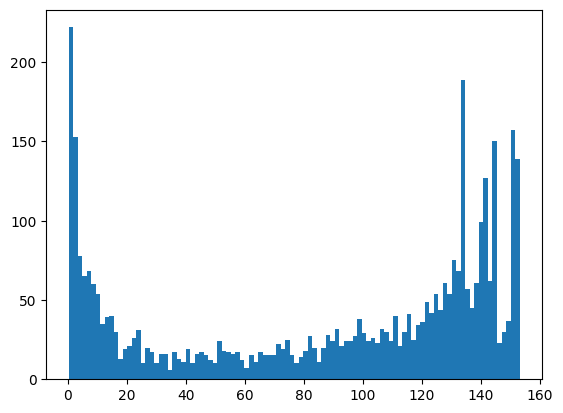

In [25]:
plt.hist(prec_diag[prec_diag > 0.], bins=100);